## ML_Homework_2



### Note: the following network will be used in Question 1, 2 and 7.

In [39]:
import random
import math


class NeuralNetwork:
    

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None,learning_rate = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_w_inp_to_hid(hidden_layer_weights)
        self.init_w_hid_to_out(output_layer_weights)
        self.learning_rate = learning_rate
    # initialize weight from input to hidden layer
    def init_w_inp_to_hid(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1
    # initialize weight from hidden layer to output
    def init_w_hid_to_out(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        d_error_out_net = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            d_error_out_net[o] = self.output_layer.neurons[o].d_error_inp(training_outputs[o])

        # 2. Hidden neuron deltas
        d_error_net_hid = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            error_out_hid = 0
            for o in range(len(self.output_layer.neurons)):
                error_out_hid += d_error_out_net[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            d_error_net_hid[h] = error_out_hid * self.hidden_layer.neurons[h].d_net_inp()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                d_error_w = d_error_out_net[o] * self.output_layer.neurons[o].d_net_w(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.learning_rate * d_error_w

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                d_error_w = d_error_net_hid[h] * self.hidden_layer.neurons[h].d_net_w(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.learning_rate * d_error_w

    def cal_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].cal_error(training_outputs[o])
        return total_error
    def test(self, test_inputs):
        return self.feed_forward(test_inputs)

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()
        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

    
class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.sigmoid(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to sigmoid the output of the neuron
    def sigmoid(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    def d_error_inp(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.d_net_inp();

    # The error for each neuron is calculated by the Mean Square Error method:
    def cal_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = -(target output - actual output)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)


    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def d_net_inp(self):
        return self.output * (1 - self.output)

    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def d_net_w(self, index):
        return self.inputs[index]


In [40]:
nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.1,0.1,0.25,0.7], hidden_layer_bias=0, output_layer_weights=[0.4,0.6,0.5,0.3], output_layer_bias=0,learning_rate=0.1)

for i in range(1):
    print('Epoch',i,'error = ', round(nn.cal_total_error([[[1,1], [0,1]]]), 6))
    nn.train([1,1], [0,1])
    for n in range(len(nn.output_layer.neurons)):
        for w_ho in range(len(nn.output_layer.neurons[n].weights)):
            print(round(nn.output_layer.neurons[n].weights[w_ho],6))
    for n in range(len(nn.hidden_layer.neurons)):
        for w_ho in range(len(nn.hidden_layer.neurons[n].weights)):
            print(round(nn.hidden_layer.neurons[n].weights[w_ho],5))
    print('Epoch',i+1,'error = ', round(nn.cal_total_error([[[1,1], [0,1]]]), 6))

Epoch 0 error =  0.324181
0.392181
0.589828
0.503063
0.303984
0.0993
0.0993
0.24868
0.69868
Epoch 1 error =  0.322236


#### Question 1 and 2

Following the above calculation, after one iteration of backpropagation, we get $w_{11}=0.099; w_{12}=0.249; w_{21}=0.099; w_{22}=0.699; w_{13}=0.392; w_{14}=0.502; w_{23}=0.591; w_{24}=0.302 $

#### Qestion 3

We will need 3 units in the first hidden layer to represent the universal components for both "F" and "L"; and we will need two units in the second hidden layer to represent the letter "F" and "L".

Please see the following for illustration:

![hello stranger](https://github.com/ccccclw/Notebooks/blob/master/ML_2020Fall/FL_nn.png?raw=true)

#### Question 4

For $E_{1}=\sum_{i=1}^{M} w_{i}^{2}$, the cost function will be $C_1 = loss + \lambda \sum_{i=1}^{M} w_{i}^{2}$

For $E_{2}=\sum_{i=1}^{M}\left|w_{i}\right|$, the cost function will be $C_2 = loss + \lambda \sum_{i=1}^{M}\left|w_{i}\right|$

Since our task is to drive the weights for unnecessary neurons to zero, we need to use $E_2$ as regularization because in this case it helps to decrease the less important features' coefficient to $0$.

A simple situation will be shown as following:

Gradient descent: $w_{\mathrm{new}}=w-\eta \frac{\partial C}{\partial w}$

For $E_1$: $\begin{aligned} w_{\text {new }} &=w-\eta \frac{\partial C_{1}}{\partial w} \\ &=w-\eta \cdot[2 x(w x+b-y)+2 \lambda w] \end{aligned}$

For $E_2$: $\begin{aligned} w_{\text {new }} &=w-\eta \frac{\partial C_{2}}{\partial w} \\ &=w-\eta \cdot\left[2 x(w x+b-y)+\lambda \frac{d|w|}{d w}\right] \\ &=\left\{\begin{array}{c}w-\eta \cdot[2 x(w x+b-y)+\lambda] & w>0 \\ w-\eta \cdot[2 x(w x+b-y)-\lambda] & w<0\end{array}\right.\end{aligned}$

In $E_2$ case: If $w$ is positive, the regularization parameter $λ>0$ will make $w$ less positive, by subtracting $λ$ from $w$; if $w$ is negative, $λ$ will be added to $w$, making it less negative. Hence, $E_2$ can make $w$ towards $0$. However, $E_1$ has $w$ associated with $\lambda$, so it cannot make network coefficient sparse.

#### Question 5

For this dice, the probability of rolling a sequence 1,2,...,6 is $p_1p_2p_3p_4p_5p_6 \geq \left(\Pi_{i} p_{i}^{p_{i}}\right)^{n / \Sigma_{i} p_{i}} = \left(\Pi_{i=1}^{6} p_{i}^{p_{i}}\right)^{6 }$, we take $\ln$ at both sides, we get $\sum_{i=1}^6 \ln p_i \geq 6\sum_{i=1}^6 p_i\ln p_i \rightarrow \sum_{i=1}^6 \ln p_i (1-6p_i) \geq 0$ under the condition that $\sum_{i=1}^6 p_i = 1$.

Let's consider the function $\ln p_i (1-6p_i)$, its second derivative is $-\frac{1}{p_i^2}-\frac{6}{p_i} < 0$, which means it's a concave function. With the property of concave function that $f\left(\right.$average of $\left.\left\{p_{i}\right\}\right) \geq$ average of $\left\{f\left(p_{i}\right)\right\}$, we get $\frac{1}{6}\sum_{i=1}^6 \ln p_i (1-6p_i) \leq \ln\frac{1}{6}(1-6*\frac{1}{6}) = 0$. 

With the above results, we conclude that the dice is fair and $p_1=p_2=p_3=p_4=p_5=p_6=\frac{1}{6} $

#### Question 6

For single-hidden-layer network, the maximum of neurons for evaluating any boolean function is $2^{n-1} = 2^3 = 8$;
for multi-layer, the minimum number of neurons required is $3(n-1) = 8 $ or $2(n-1) = 6$ when XOR is modeled by two-neuron model. We can see that by increasing the number of layers sufficiently, we can reduce the number of neurons necessary to evalute a given function exponentially.

#### Question 7

(Note: the code for network construction is at the top.)

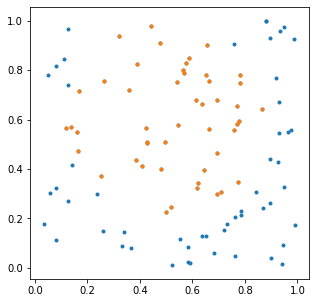

In [99]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
n = 100
xy_min = [0, 0]
xy_max = [1, 1]
train_data = np.random.uniform(low=xy_min, high=xy_max, size=(n,2))
plt.scatter(train_data[:,0],train_data[:,1],marker='.')
data_square = (train_data[:,0]-0.5)**2 + (train_data[:,1]-0.6)**2
right=data_square < 0.4**2
wrong=data_square >= 0.4**2
True_data=train_data[right]
False_data=train_data[wrong]
plt.scatter(True_data[:,0],True_data[:,1],marker='.')

Epoch  0 | weights:  [0.08, 0.36, 0.51, 0.8, 0.35, 0.37, 0.8, 0.95, 0.4, 0.06, 0.18, 0.77, 0.16, 0.09, 0.85, 0.32, 0.78, 0.08, 0.12, 0.69] | bias 0.52

Epoch  200 | weights:  [-1.01, -0.83, 0.26, 0.58, -1.32, -0.37, -0.42, 0.83, -0.31, -6.85, -1.43, -0.18, -5.29, -1.56, 0.54, 0.34, 0.45, 0.49, -1.85, 0.57] | bias 0.52

Epoch  400 | weights:  [-1.43, -0.44, 0.64, 0.42, -1.58, -0.26, -0.1, 0.76, 0.19, -8.69, -1.66, -0.18, -8.92, 0.35, 0.79, 0.29, 0.75, 0.35, -2.08, 0.33] | bias 0.52

Epoch  600 | weights:  [-1.53, -0.45, 0.8, 0.34, -1.59, -0.38, 0.2, 0.69, -0.02, -8.24, -1.62, -0.35, -8.47, 0.82, 0.88, 0.28, 0.86, 0.3, -1.86, -0.07] | bias 0.52

Epoch  800 | weights:  [-1.63, -0.47, 0.89, 0.3, -1.65, -0.45, 0.43, 0.56, -0.29, -7.89, -1.66, -0.44, -8.15, 0.6, 0.93, 0.27, 0.92, 0.28, -1.75, -0.34] | bias 0.52

--------------------------------
Different initial weight trial 1
weights:  [0.37, 0.77, 0.64, 0.54, -1.0, -0.67, -4.11, 2.42, -2.76, 11.83, 0.64, 0.54, 0.55, 0.48, 0.61, 0.55, -7.77

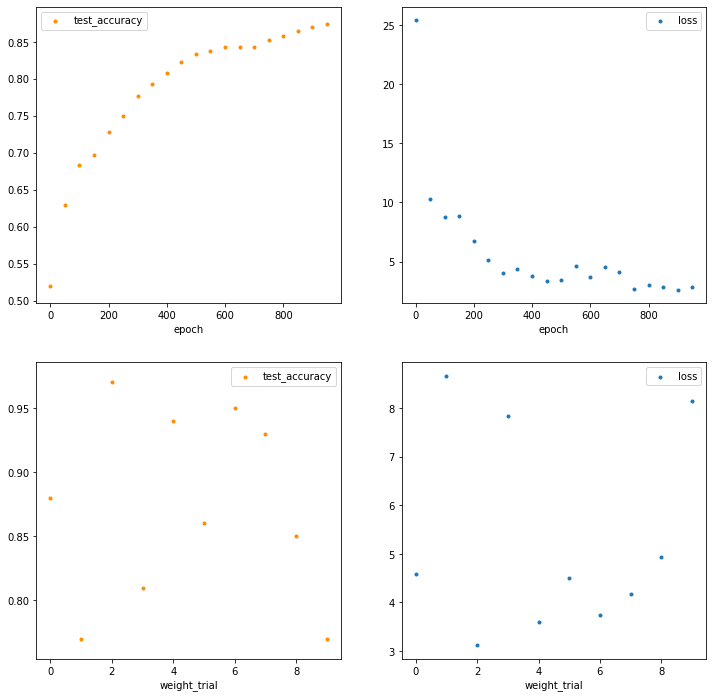

In [100]:
# training dataset
training_sets = [[list(True_data[i]),[1]] for i in range(len(True_data))]+ \
              [[list(False_data[i]),[0]] for i in range(len(False_data))]

# testing dataset
test_data = np.random.uniform(low=xy_min, high=xy_max, size=(n,2))
test_square = (test_data[:,0]-0.5)**2 + (test_data[:,1]-0.6)**2
test_right = test_square < 0.4**2
test_wrong = test_square >= 0.4**2
True_data = test_data[test_right]
False_data = test_data[test_wrong]


nn = NeuralNetwork(len(training_sets[0][0]), 10, len(training_sets[0][1]),learning_rate=0.5)
test_accuracy = []
epoch = []
loss = []
result=[]

# different epochs
for i in range(100000):
    hidden_weights = []
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    if i % 5000==0:
        epoch.append(int(i/100))
        loss.append(round(nn.cal_total_error(training_sets),4))
        for index,v in enumerate(test_data):
            a = nn.test(v)
            if abs(a[0]-1) < abs(a[0]):
                a = True
            else:
                a = False
            if test_right[index] == a:
                result.append(1)
            else:
                result.append(0)
        test_accuracy.append(round(sum(result)/len(result),4))

    if i % 20000==0:
        for n in range(len(nn.hidden_layer.neurons)):
            for w_ho in range(len(nn.hidden_layer.neurons[n].weights)):
                hidden_weights.append(round(nn.hidden_layer.neurons[n].weights[w_ho],2))
        print('Epoch ', int(i/100),'|','weights: ',hidden_weights,'|','bias',round(nn.hidden_layer.neurons[1].bias,2))
        print('')
        
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0][0].scatter(epoch, test_accuracy,marker='.',label='test_accuracy',color='darkorange')
ax[0][0].set_xlabel('epoch')
ax[0][1].set_xlabel('epoch')
ax[0][1].scatter(epoch, loss,marker='.',label='loss')
ax[0][0].legend()
ax[0][1].legend()
print('--------------------------------')
# different initial weights

weights = [i for i in range(10)]
test_accuracy = []
loss = []
for weight in range(10):
    result=[]
    hidden_weights = []
    nn = NeuralNetwork(len(training_sets[0][0]), 10, len(training_sets[0][1]),learning_rate=0.5)
    for i in range(50000):
        training_inputs, training_outputs = random.choice(training_sets)
        nn.train(training_inputs, training_outputs)

    loss.append(round(nn.cal_total_error(training_sets),4))
    for index,v in enumerate(test_data):
        a = nn.test(v)
        if abs(a[0]-1) < abs(a[0]):
            a = True
        else:
            a = False
        if test_right[index] == a:
            result.append(1)
        else:
            result.append(0)
    test_accuracy.append(round(sum(result)/len(result),4))
    print('Different initial weight trial', weight+1)
    for n in range(len(nn.hidden_layer.neurons)):
        for w_ho in range(len(nn.hidden_layer.neurons[n].weights)):
            hidden_weights.append(round(nn.hidden_layer.neurons[n].weights[w_ho],2))
    print('weights: ',hidden_weights,'|','bias',round(nn.hidden_layer.neurons[1].bias,2))
ax[1][0].scatter(weights, test_accuracy,marker='.',label='test_accuracy',color='darkorange')
ax[1][0].set_xlabel('weight_trial')
ax[1][1].set_xlabel('weight_trial')
ax[1][1].scatter(weights, loss,marker='.',label='loss')
ax[1][0].legend()
ax[1][1].legend()


Following the above results for training different iterations and starting from different weights, we found that training sufficiently more iterations could lead better prediction accuracy, but we have to keep in mind that it is possible to cause overfitting for training too many iterations, so combining training and validation loss and compute ROC, AUC may help on evaluating this. Different initial weights could lead to different prediction accuracy, I think it may be better to use the average of different trained models selectively.